# 債務不履行リスクの低減
https://signate.jp/competitions/294  
上記のデータコンペ練習問題に取り組んだ。  

目的変数は、loan_status (=借入金を返済したかどうか)。  
ChargedOffを1、FullyPaidを0として予測。
testデータの説明変数から、testデータのloan_tatusがどちらかを予測するモデルを作成。  
評価指標は、F1スコア。

# 全体のまとめ
< EDA >  
データの概観確認、欠損値の除外、データの分布確認、目的変数・説明変数の相関確認を行なった。
  
< モデル構築 >  
説明変数を、['loan_amnt', 'interest_rate', 'credit_score', 'term', 'grade', 'purpose', 'application_type']、目的変数'loan_status' としてモデルを構築した。
hold-outでtrainデータを学習用データ: 評価用データ=7:3に分割。   
数値カラムを標準化してロジスティック回帰モデルを作成し、学習用データで学習した。  
学習したモデルの評価結果からf1スコアが最も高くなった閾値を求め、その閾値で分類を行なった。  
f1スコア最大値: 0.397  
モデル学習にかかった時間: 31.05秒  
このモデルから、testデータの'loan_status'を予測し、提出。  
提出結果: 0.394    


# データの概観確認

id:  顧客ID（インデックスとして使用）  
loan_amnt:  借入総額  
term:  返済期間  
interest_rate:	金利  
grade:	グレード  
employment_length:	勤続年数  
purpose:   借入の目的  
credit_score:   信用スコア  
application_type:   借入時の申請方式  
loan_status:   返済状況（目的変数）  
  

In [1]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from scipy.stats import hmean
from sklearn.decomposition import PCA
import time

In [2]:
# データ読み込み
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv('submit.csv', header=None)

In [3]:
print('train_shape:', train.shape)
print('test_shape:', test.shape)

train_shape: (242156, 10)
test_shape: (26906, 9)


目的変数は、loan_status。  
完済がFullyPaidで、貸し倒れがChargedOff。  
testデータの説明変数から、顧客が貸し倒れるかどうかを予測するモデルを作成。

In [4]:
# 目的変数の各値と個数を確認
# FullyPaidとChargedOffは含まれる数が大きく異なるため、データ分割の際は注意。
train['loan_status'].value_counts()

FullyPaid     193815
ChargedOff     48341
Name: loan_status, dtype: int64

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242156 entries, 0 to 242155
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 242156 non-null  int64  
 1   loan_amnt          242156 non-null  float64
 2   term               242156 non-null  object 
 3   interest_rate      242156 non-null  float64
 4   grade              242156 non-null  object 
 5   employment_length  228971 non-null  object 
 6   purpose            242156 non-null  object 
 7   credit_score       242156 non-null  float64
 8   application_type   242156 non-null  object 
 9   loan_status        242156 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 18.5+ MB


In [6]:
train = train.drop(columns=['id'])
test = test.drop(columns=['id'])

# train.info()から、employment_lengthに欠損値があることを確認。
# データの件数としては多いので、欠損値補完ではなく欠損値があるものは削除する
train = train.dropna()
print('train_shape:', train.shape)
print('test_shape:', test.shape)
# trainの行数が減ったことを確認

train_shape: (228971, 9)
test_shape: (26906, 8)


In [7]:
train.head()

,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status
1,1200.0,5 years,16.29,C4,2 years,debt_consolidation,700.0,Individual,ChargedOff
2,2000.0,5 years,21.98,E4,10 years,home_improvement,670.0,Individual,FullyPaid
3,1000.0,3 years,8.59,A5,4 years,debt_consolidation,710.0,Individual,FullyPaid
4,1500.0,3 years,13.99,C1,4 years,debt_consolidation,680.0,Individual,FullyPaid
5,310.0,3 years,7.35,A4,3 years,major_purchase,790.0,Individual,FullyPaid


In [8]:
train.describe()

,loan_amnt,interest_rate,credit_score
count,228971.000000,228971.000000,228971.000000
mean,1433.415476,13.992611,697.338484
std,875.149218,4.846862,31.715229
min,100.000000,5.320000,660.000000
25%,780.000000,10.640000,675.000000
50%,1200.000000,13.490000,690.000000
75%,2000.000000,16.990000,715.000000
max,4000.000000,30.990000,845.000000


In [9]:
train.describe(include=['O'])

,term,grade,employment_length,purpose,application_type,loan_status
count,228971,228971,228971,228971,228971,228971
unique,2,35,11,13,2,2
top,3 years,B3,10 years,debt_consolidation,Individual,FullyPaid
freq,177580,16060,79095,133880,223790,184426


# 量的データの分布確認

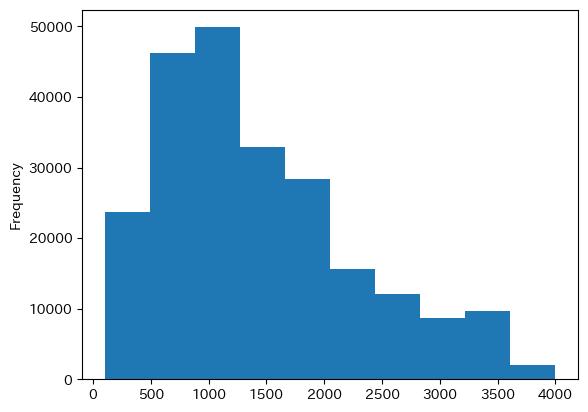

In [10]:
train['loan_amnt'].plot.hist()
plt.show()

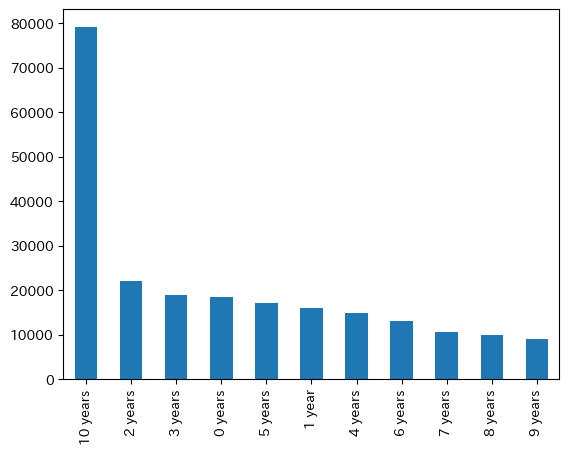

In [11]:
train['employment_length'].value_counts().plot.bar()
plt.show()

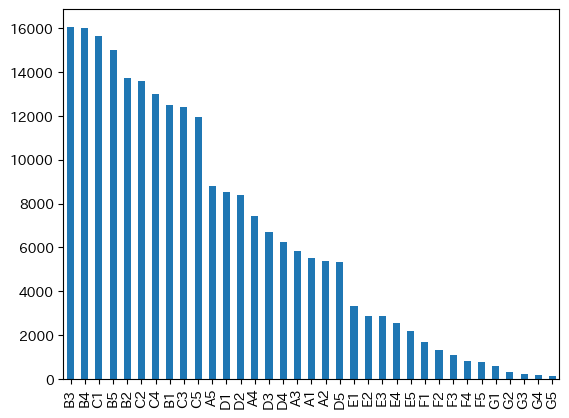

In [12]:
train['grade'].value_counts().plot.bar()
plt.show()

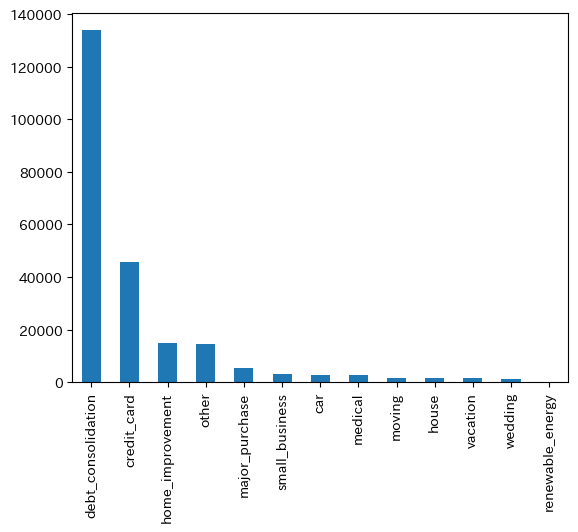

In [13]:
train['purpose'].value_counts().plot.bar()
plt.show()

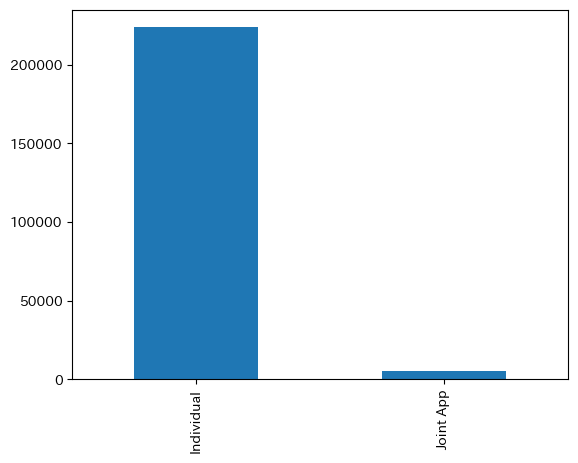

In [14]:
train['application_type'].value_counts().plot.bar()
plt.show()

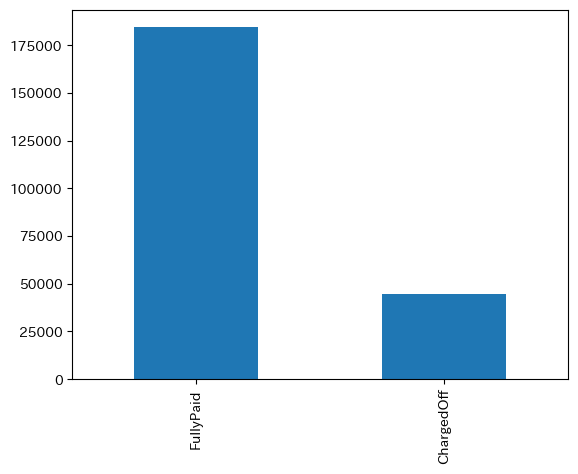

In [15]:
train['loan_status'].value_counts().plot.bar()
plt.show()

# 目的変数と説明変数の相関の確認

<仮説>  
借入総額(loan_amnt)が多いほど貸し倒れる  
返済期間(term)が長いほど貸し倒れる  
金利(interest_rate)が高いほど貸し倒れる  
勤務期間(employment_length)が短いほど貸し倒れる  
グレード(grade)と貸し倒れは相関がある  
信用スコア(credit_score)が低いほど貸し倒れる  
目的(purpose)によって貸し倒れ率は異なる  
借入時の申請方式(application_type)によって貸し倒れ率は異なる  
  

<EDAまとめ>  
貸し倒れる場合の方が借入総額が若干高い傾向にある (説明変数: ['loan_amnt'])  
貸し倒れる場合の方が金利が高い傾向にある (説明変数:  ['interest_rate'])  
貸し倒れる場合の方が信用スコアが低い傾向にある (説明変数:  ['credit_score'])  
返済期間が長いほど貸し倒れる傾向にある (説明変数:  ['term'])  
勤続年数によって貸し倒れ率に大きな差はない (説明変数:  ['employment_length'])  
グレードによって貸し倒れ率に大きな差がある。グレードAは貸し倒れ率が低く、グレードGは貸し倒れ率が高くなる傾向にある。 (説明変数: ['grade'])  
目的によって貸し倒れ率に大きな差がある。weddingは貸し倒れ率が低く、small_businessは貸し倒れ率が高い。 (説明変数: ['purpose'])  
JointAppのほうが少し貸し倒れ率が高い。(JointApp: 0.255, Individual: 0.193)  (説明変数: ['application_type'])  

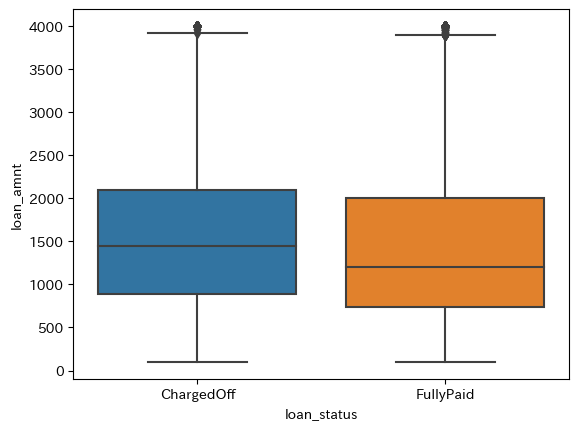

In [16]:
sns.boxplot(x='loan_status', y='loan_amnt', data=train)
plt.show()
# 貸し倒れる場合の方が借入総額が若干高い傾向にある

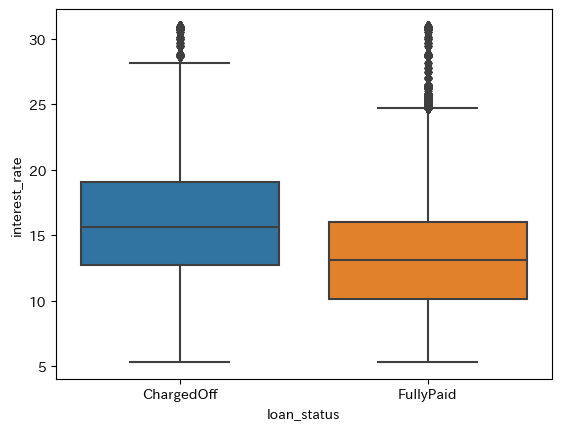

In [17]:
sns.boxplot(x='loan_status', y='interest_rate', data=train)
plt.show()
# 貸し倒れる場合の方が金利が若干高い傾向にある

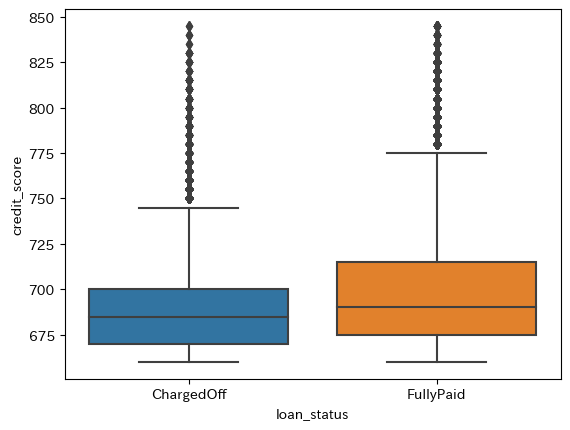

In [18]:
sns.boxplot(x='loan_status', y='credit_score', data=train)
plt.show()
# 貸し倒れる場合の方が信用スコアが若干低い傾向にある

In [19]:
ct_term = pd.crosstab(train['term'], train['loan_status'], margins=True)
ct_term['charged_off_rate'] = ct_term['ChargedOff'] / ct_term['All']
ct_term['fully_paid_rate'] = ct_term['FullyPaid'] / ct_term['All']

ct_term

loan_status,ChargedOff,FullyPaid,All,charged_off_rate,fully_paid_rate
term,,,,,
3 years,29339,148241,177580,0.165216,0.834784
5 years,15206,36185,51391,0.295888,0.704112
All,44545,184426,228971,0.194544,0.805456


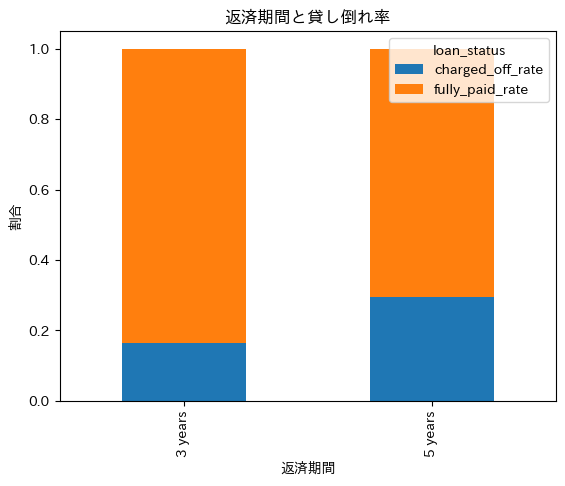

In [20]:
ct_term = ct_term.drop(index=['All'])
ct_term[['charged_off_rate', 'fully_paid_rate']].plot.bar(stacked=True)
plt.title('返済期間と貸し倒れ率')
plt.xlabel('返済期間')
plt.ylabel('割合')
plt.show()
# 返済期間が長いほど貸し倒れる傾向にある

In [21]:
ct_emp_len = pd.crosstab(train['employment_length'], train['loan_status'], margins=True)
ct_emp_len['charged_off_rate'] = ct_emp_len['ChargedOff'] / ct_emp_len['All']
ct_emp_len['fully_paid_rate'] = ct_emp_len['FullyPaid'] / ct_emp_len['All']
ct_emp_len

loan_status,ChargedOff,FullyPaid,All,charged_off_rate,fully_paid_rate
employment_length,,,,,
0 years,3899,14612,18511,0.210632,0.789368
1 year,3219,12664,15883,0.202670,0.797330
10 years,15013,64082,79095,0.189810,0.810190
2 years,4318,17780,22098,0.195402,0.804598
3 years,3805,14967,18772,0.202696,0.797304
4 years,2933,11962,14895,0.196912,0.803088
5 years,3271,13724,16995,0.192468,0.807532
6 years,2461,10666,13127,0.187476,0.812524
7 years,1998,8680,10678,0.187114,0.812886


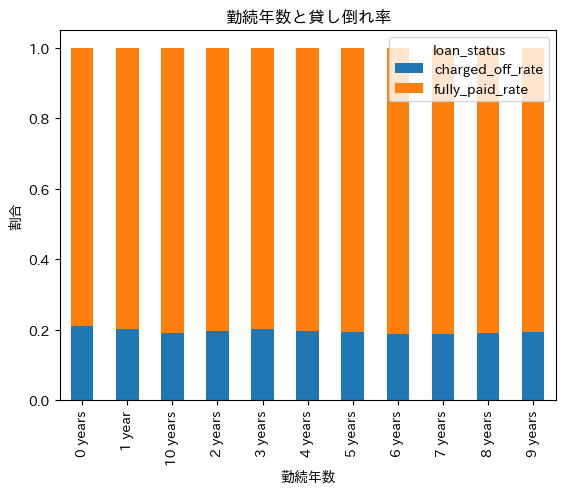

In [22]:
ct_emp_len = ct_emp_len.drop(index=['All'])
ct_emp_len[['charged_off_rate', 'fully_paid_rate']].plot.bar(stacked=True)
plt.title('勤続年数と貸し倒れ率')
plt.xlabel('勤続年数')
plt.ylabel('割合')
plt.show()
# 勤続年数によって貸し倒れ率に大きな差はない

In [23]:
ct_grade = pd.crosstab(train['grade'], train['loan_status'], margins=True)
ct_grade['charged_off_rate'] = ct_grade['ChargedOff'] / ct_grade['All']
ct_grade['fully_paid_rate'] = ct_grade['FullyPaid'] / ct_grade['All']
ct_grade

loan_status,ChargedOff,FullyPaid,All,charged_off_rate,fully_paid_rate
grade,,,,,
A1,194,5316,5510,0.035209,0.964791
A2,244,5128,5372,0.045421,0.954579
A3,337,5486,5823,0.057874,0.942126
A4,539,6916,7455,0.072300,0.927700
A5,744,8054,8798,0.084565,0.915435
B1,1320,11180,12500,0.105600,0.894400
B2,1483,12244,13727,0.108035,0.891965
B3,1966,14094,16060,0.122416,0.877584
B4,2319,13709,16028,0.144684,0.855316


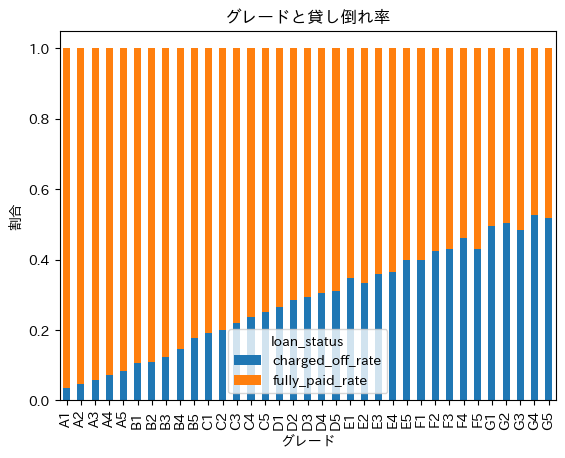

In [24]:
ct_grade = ct_grade.drop(index=['All'])
ct_grade[['charged_off_rate', 'fully_paid_rate']].plot.bar(stacked=True)
plt.title('グレードと貸し倒れ率')
plt.xlabel('グレード')
plt.ylabel('割合')
plt.show()
# グレードによって貸し倒れ率に大きな差がある。グレードAは貸し倒れ率が低く、グレードGは貸し倒れ率が高くなる傾向にある。

In [25]:
ct_purpose = pd.crosstab(train['purpose'], train['loan_status'], margins=True)
ct_purpose['charged_off_rate'] = ct_purpose['ChargedOff'] / ct_purpose['All']
ct_purpose['fully_paid_rate'] = ct_purpose['FullyPaid'] / ct_purpose['All']
ct_purpose

loan_status,ChargedOff,FullyPaid,All,charged_off_rate,fully_paid_rate
purpose,,,,,
car,387,2338,2725,0.142018,0.857982
credit_card,7469,38214,45683,0.163496,0.836504
debt_consolidation,27339,106541,133880,0.204205,0.795795
home_improvement,2604,12439,15043,0.173104,0.826896
house,333,1290,1623,0.205176,0.794824
major_purchase,1003,4423,5426,0.184851,0.815149
medical,531,2046,2577,0.206054,0.793946
moving,358,1325,1683,0.212715,0.787285
other,3077,11250,14327,0.214769,0.785231


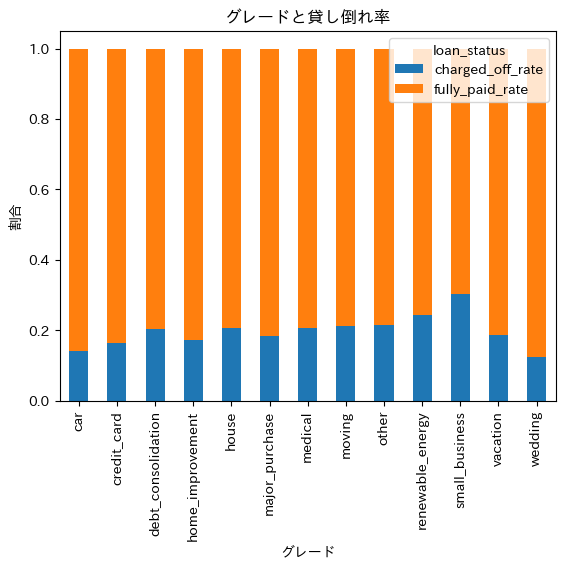

In [26]:
ct_purpose = ct_purpose.drop(index=['All'])
ct_purpose[['charged_off_rate', 'fully_paid_rate']].plot.bar(stacked=True)
plt.title('グレードと貸し倒れ率')
plt.xlabel('グレード')
plt.ylabel('割合')
plt.show()
# 目的によって貸し倒れ率に大きな差がある。weddingは貸し倒れ率が低く、small_businessは貸し倒れ率が高い。

In [27]:
ct_ap_type = pd.crosstab(train['application_type'], train['loan_status'], margins=True)
ct_ap_type['charged_off_rate'] = ct_ap_type['ChargedOff'] / ct_ap_type['All']
ct_ap_type['fully_paid_rate'] = ct_ap_type['FullyPaid'] / ct_ap_type['All']
ct_ap_type

loan_status,ChargedOff,FullyPaid,All,charged_off_rate,fully_paid_rate
application_type,,,,,
Individual,43223,180567,223790,0.193141,0.806859
Joint App,1322,3859,5181,0.255163,0.744837
All,44545,184426,228971,0.194544,0.805456


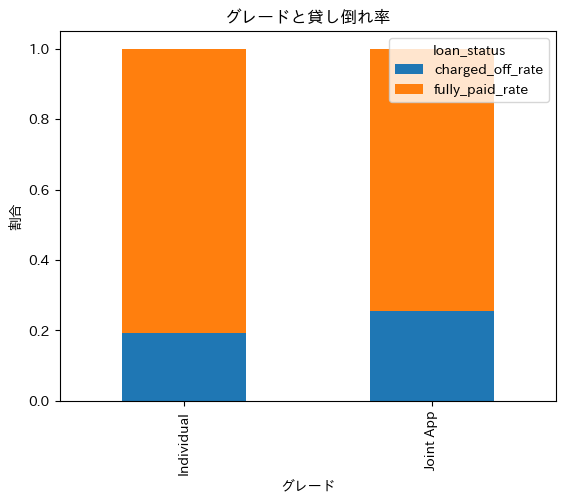

In [28]:
ct_ap_type = ct_ap_type.drop(index=['All'])
ct_ap_type[['charged_off_rate', 'fully_paid_rate']].plot.bar(stacked=True)
plt.title('グレードと貸し倒れ率')
plt.xlabel('グレード')
plt.ylabel('割合')
plt.show()
# JointAppのほうが少し貸し倒れ率が高い。(JointApp: 0.255, Individual: 0.193)

## モデル構築
説明変数は、['loan_amnt', 'interest_rate', 'credit_score', 'term', 'grade', 'purpose', 'application_type']、目的変数は'loan_status' 

hold-outでtrainデータを学習用データ: 評価用データ=7:3に分割。   
数値カラムを標準化してロジスティック回帰モデルを作成し、学習用データで学習した。
学習したモデルの評価結果からf1スコアが最も高くなった閾値を求め、その閾値で分類を行なった。  
f1スコア最大値: 0.397  
そのときの閾値: 0.194  
このモデルから、testデータの'loan_status'を予測し、提出。  
  
提出結果: 0.394    
モデル学習にかかった時間: 31.05秒  
   

In [29]:
# trainデータの説明変数と目的変数
X = train.drop(columns=['employment_length', 'loan_status'])
y = train['loan_status']

# ダミー変数化する前に数値カラムのリストを取得
numeric_cols = X.select_dtypes(include=np.number).columns.to_list()

# ダミー変数化
X = pd.get_dummies(X, drop_first=True)
y = pd.get_dummies(y)
y = y['ChargedOff']

In [30]:
# trainデータを学習用と評価用に分割し、学習用データでロジスティック回帰モデルを学習
X_train, X_val, y_train, y_val=train_test_split(X, y,random_state=0, stratify=y)
# 数値カラムを標準化
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])

#ロジスティック回帰
lr = LogisticRegression(penalty='l2', solver='lbfgs')
before = time.time()
lr.fit(X_train, y_train)
after = time.time()
pred_proba = lr.predict_proba(X_val)
proba_df = pd.DataFrame(pred_proba)
print(f'学習にかかった時間: {after-before:.2f}秒')

学習にかかった時間: 31.05秒


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
# 学習したモデルの評価結果から、それぞれの閾値でのprecision, recallを求める
precision, recall, thresholds = precision_recall_curve(y_val, pred_proba[:, 1])

In [32]:
# 上記のprecisionとrecallからf1スコアを求める
f1_scores = [hmean([p, r]) for p, r in zip(precision, recall)]

24570番目の閾値(=0.194)のとき、f1スコアが最も高い(f1=0.397)


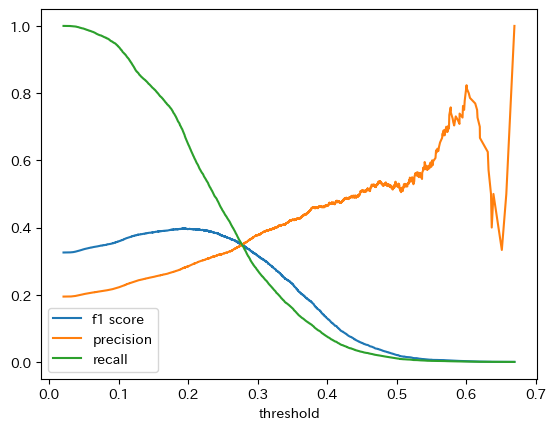

In [33]:
# それぞれの閾値でのprecision, recall, f1スコアをプロット 
plt.plot(thresholds, f1_scores[:-1], label='f1 score')
plt.plot(thresholds, precision[:-1], label='precision')
plt.plot(thresholds, recall[:-1], label='recall')
plt.xlabel('threshold')
plt.legend()
print(f'{np.argmax(f1_scores)}番目の閾値(={thresholds[np.argmax(f1_scores)]:.3f})のとき、f1スコアが最も高い(f1={np.max(f1_scores):.3f})')
plt.show()

In [34]:
max_f1_threshold = thresholds[np.argmax(f1_scores)]

In [35]:
# f1スコアが最大となった閾値で分類し、classificationカラムに結果を代入
proba_df['classification'] = proba_df[1].apply(lambda x: 1 if x >= max_f1_threshold else 0)

In [36]:
print(f'モデル① trainデータでの最大f1スコア: {np.max(f1_scores):.3f}')

モデル① trainデータでの最大f1スコア: 0.397


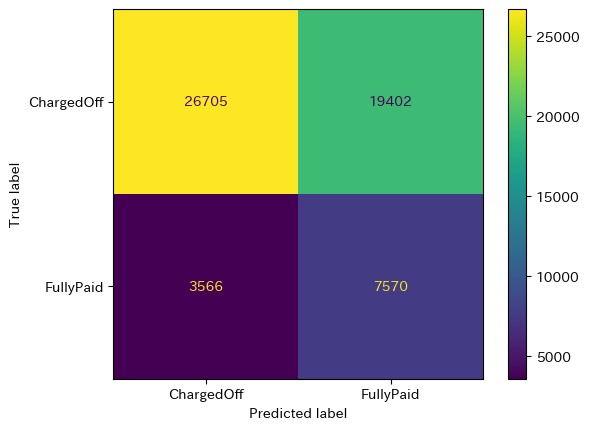

In [37]:
# 混同行列を表示
cm = confusion_matrix(y_val, proba_df['classification'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ChargedOff', 'FullyPaid'])
disp.plot()

In [38]:
# testデータの説明変数
X_test = test.drop(columns=['employment_length'])
X_test = pd.get_dummies(X_test, drop_first=True)

# 数値カラムを標準化
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [39]:
# 学習したモデルで予測
pred_proba_test = lr.predict_proba(X_test)
proba_df_test = pd.DataFrame(pred_proba_test)

In [40]:
# 学習モデルにおいてf1スコアが最大となった閾値で分類し、classificationカラムに結果を代入
proba_df_test['classification'] = proba_df_test[1].apply(lambda x: 1 if x >= max_f1_threshold else 0)

In [41]:
proba_df_test.head()

,0,1,classification
0,0.895018,0.104982,0
1,0.894607,0.105393,0
2,0.812275,0.187725,0
3,0.746429,0.253571,1
4,0.769509,0.230491,1


In [42]:
submit[1] = proba_df_test['classification']
# submit.to_csv('submission_3.csv', header=None, index=False)